In [ ]:
# 한글 폰트 설치

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

# 모듈 import

In [ ]:
!pip install shap lightgbm pca

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 5.8 MB/s eta 0:00:00


# 데이터 불러오기

In [ ]:
file_path = 'train_OutlierRemoval.csv'
data = pd.read_csv(file_path)

# Drop unnecessary columns and split into X and y
X = data.drop(['label', 'Unnamed: 0', 'ID','콜레스테롤'], axis=1)
y = data['label']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.head()

,나이,키(cm),몸무게(kg),시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,고밀도지단백,저밀도지단백,헤모글로빈,요 단백,간 효소율
1612,55,145,45,0.90,0,95,46.0,88,0.8,93.000000,207.0,13.5,1,1.14
978,55,160,55,0.50,0,94,42.0,107,0.7,100.876263,81.0,14.6,1,1.15
3050,40,170,60,1.35,0,102,28.0,230,1.0,40.000000,157.0,16.0,1,1.60
4960,55,165,55,0.90,1,101,54.0,47,0.9,54.000000,124.0,12.8,1,1.11
2548,60,170,65,1.00,0,98,40.0,173,0.9,25.000000,55.0,15.8,1,0.88


# 데이터 스케일링

In [ ]:
# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 모델링

In [ ]:
# LightGBM 모델
model = lgb.LGBMClassifier()

# GridSearchCV
param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_split_gain': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

# Perform GridSearchCV
grid_search = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# 최적의 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# 최적의 파라미터 출력
print("Best parameters found: ", grid_search.best_params_)
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred_proba))

[LightGBM] [Info] Number of positive: 1808, number of negative: 3092
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the train set: 4900, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368980 -> initscore=-0.536597
[LightGBM] [Info] Start training from score -0.536597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

# 성능평가

정확도: 0.7214285714285714
정밀도: 0.6146907216494846
재현율: 0.6251638269986893
F1 Score: 0.6198830409356726
ROC AUC: 0.7961212824627426


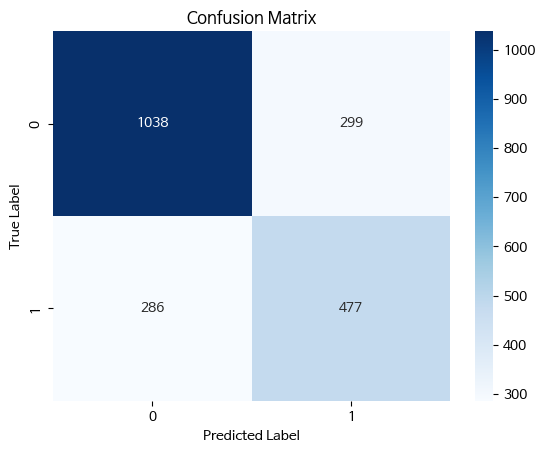

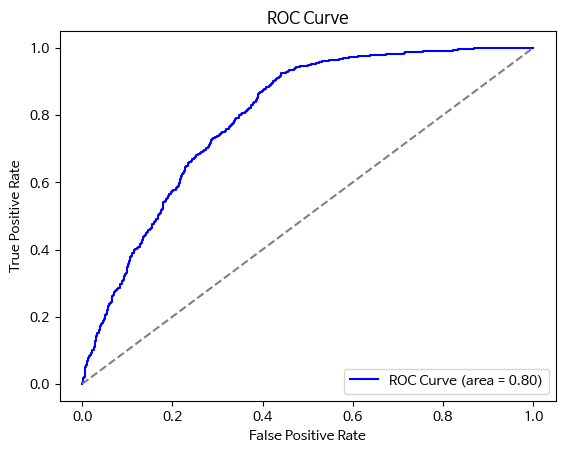

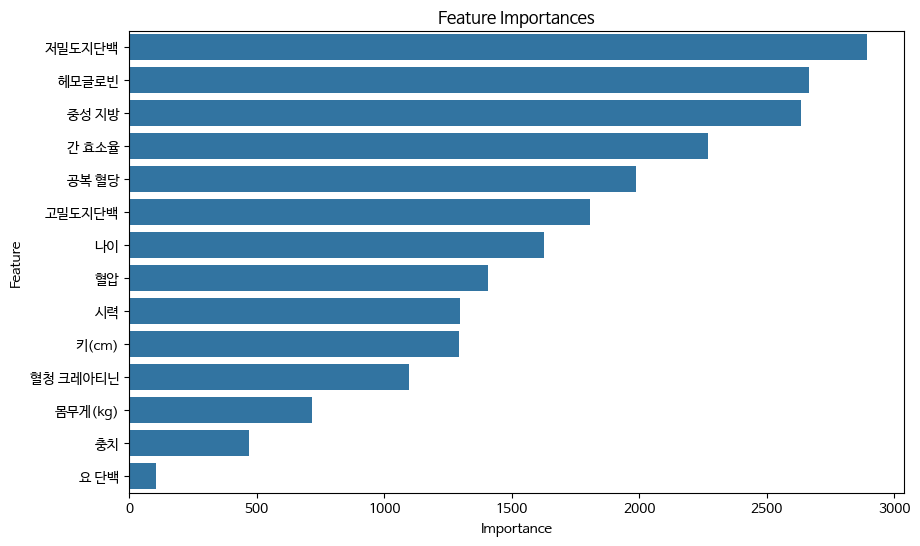

In [ ]:
# 성능평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'정확도: {accuracy}')
print(f'정밀도: {precision}')
print(f'재현율: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

# 혼돈행렬
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Feature importance
feature_importances = best_model.feature_importances_

feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 교차 검증

In [ ]:
# K-fold 교차 검증
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(best_model, X_train_scaled, y_train, cv=kf, scoring='accuracy')

print(f'Cross-Validation accuracy scores: {cv_results}')
print(f'Mean accuracy: {cv_results.mean():.4f}')

[LightGBM] [Info] Number of positive: 1441, number of negative: 2479
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 3920, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.367602 -> initscore=-0.542518
[LightGBM] [Info] Start training from score -0.542518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

# SHAP

 99%|===================| 4875/4900 [03:08<00:00]       

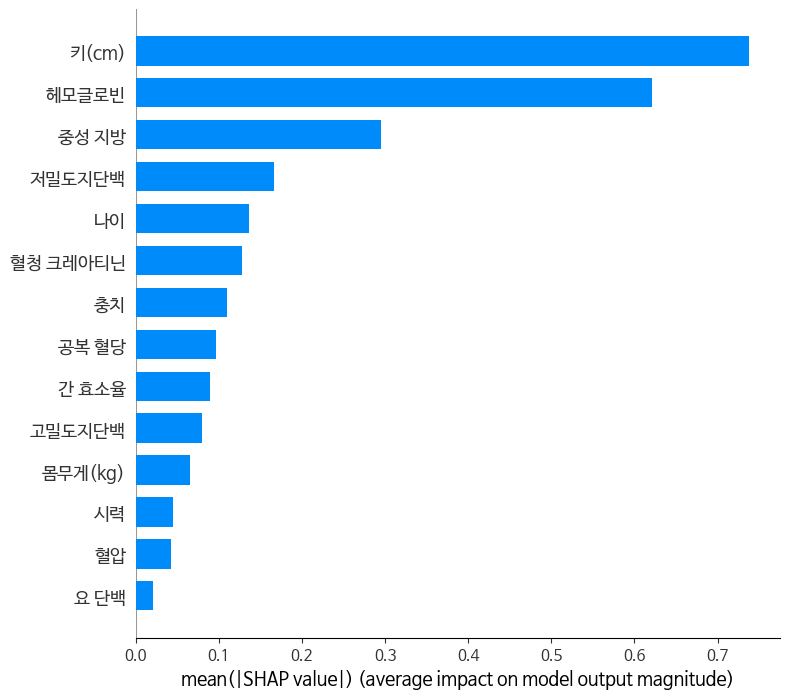

/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:962: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  pl.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


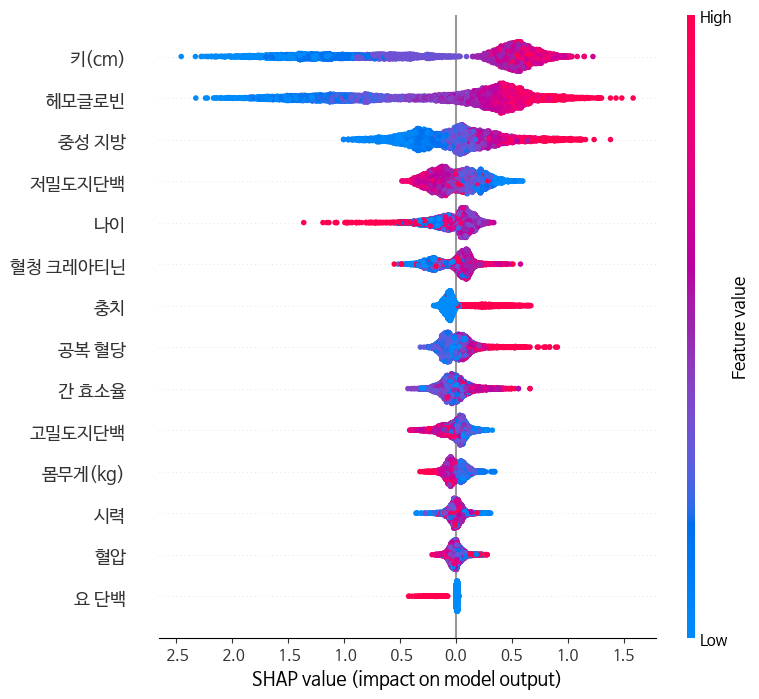

In [ ]:
# SHAP 분석
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_train_scaled, check_additivity=False)

# Global feature importance
shap.summary_plot(shap_values, features=X_train_scaled, feature_names=X.columns, plot_type="bar")

# Local explanation summary
shap.summary_plot(shap_values, features=X_train_scaled, feature_names=X.columns)